In [1]:
import pandas as pd
from pathlib import Path
import multiprocessing as mp
from tqdm.notebook import tqdm

In [2]:
# task_dir = Path('/home/hplt/hplt/three/code/warc2text-runner/three/cesnet_ia')
# logs_dir = Path('/home/hplt/hplt/three/log_html')

task_dir = Path('/home/hplt/hplt/three/code/warc2text-runner/three/cesnet_cc1')
logs_dir = Path('/home/hplt/hplt/three/html_cesnet_cc1/')

max_warcs = 1000

In [3]:
def file_size(path): 
    return Path(path).stat().st_size


def read_tasks(task_dir):
    tdf = pd.read_csv(task_dir/'tasks.args.gz', sep=' ', names=list(range(max_warcs+5)), header=None)

    warcs_ser = tdf.loc[:,4:].apply(lambda r: [e for e in r if not pd.isnull(e)], axis=1)
    tdf = tdf.drop(columns=[0]+list(tdf.columns[4:]))
    tdf['warcs'] = warcs_ser
    tdf = tdf.rename(columns={1:'batch',2:'outdir', 3:'indir'})
    print(len(tdf), 'tasks')
    tdf = tdf.explode('warcs')
    print(len(tdf), 'WARC files')
    with mp.Pool(30) as pool:
        results = pool.map(file_size, tqdm(list(tdf.indir + '/' + tdf.warcs)))
    
    tdf['size'] = results
    return tdf

In [4]:
tdf_path = Path(task_dir)/'warc_size.tsv'
if not tdf_path.exists():
    tdf = read_tasks(task_dir)
    tdf.to_csv(tdf_path, sep='\t', index=False)
tdf = pd.read_csv(tdf_path, sep='\t')

In [5]:
import re
pat = re.compile(r'(?:hostname: (?P<hostname>.*))|(\[(?P<start>.*)\] \[info\] (?:.*Processing (?P<warcs>.*)|(?P<finished>elapsed)))')

In [6]:
dfs = []
for p in tqdm(list(logs_dir.glob('*_logs/*.stderr'))):
    with open(p, 'r') as inp:
        q = [match.groupdict() for l in inp if (match := pat.match(l))]
        hostname = q[0].get('hostname')
        if hostname:
            q = q[1:]
        else:
            hostname = 'unknown hostname'
            
        if q[-1]['finished']:
            finished = q[-1].get('start')
            q = q[:-1]
        else:
            finished = None

        df = pd.DataFrame(q).drop(columns=['finished'])
        df['hostname'] = hostname
        df['start'] = pd.to_datetime(df.start)
        df['end'] = df['start'].shift(-1)
        df.iloc[-1,-1] = finished
        df['dur_min'] =  (df.end.fillna(pd.Timestamp.now())-df.start)
        
        df['outdir'] = str(p.parent).replace('_logs','')
        dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

  0%|          | 0/316 [00:00<?, ?it/s]

In [7]:
# df.outdir = df.outdir.str.replace('log_', '')

In [8]:
df1 = df.merge(tdf, how='inner',on=['outdir','warcs'])
assert len(df) == len(df1), f'{len(df)}!={len(df1)}'
df = df1

In [9]:
df['TB/day min'] = (df['size'] / 2**40 / (df.end-df.start).dt.seconds * 3600 * 24).fillna(0.0)
df['TB/day max'] = (df['size'] / 2**40 / df.dur_min.dt.seconds * 3600 * 24)


In [10]:
def overlapping_mask(df, ts):
    return (df.start <= ts) & ((df.end > ts) | df.end.isnull())

gdf = pd.DataFrame(pd.date_range(df.start.min(), df.end.fillna(pd.Timestamp.now()).max(), freq='min'))
sdf = gdf[0].apply(lambda ts: df[overlapping_mask(df, ts)][['TB/day min','TB/day max']].sum())
sdf['nwarcs'] = gdf[0].apply(lambda ts: overlapping_mask(df, ts).sum())
for host in df.hostname.unique():
    df1 = df[df.hostname==host]
    sdf1 = gdf[0].apply(lambda ts: df1[overlapping_mask(df1, ts)][['TB/day min','TB/day max']].sum())
    sdf1['nwarcs'] = gdf[0].apply(lambda ts: overlapping_mask(df1, ts).sum())
    sdf1.rename(columns={c:f'{host}:{c}' for c in sdf1.columns}, inplace=True)
    sdf = pd.concat([sdf,sdf1], axis=1)

sdf['ts'] = gdf[0]
sdf

,TB/day min,TB/day max,nwarcs,mon005-cl3-mka-ova1.du.cesnet.cz:TB/day min,mon005-cl3-mka-ova1.du.cesnet.cz:TB/day max,mon005-cl3-mka-ova1.du.cesnet.cz:nwarcs,mon004-cl3-mka-ova1.du.cesnet.cz:TB/day min,mon004-cl3-mka-ova1.du.cesnet.cz:TB/day max,mon004-cl3-mka-ova1.du.cesnet.cz:nwarcs,mon006-cl3-mka-ova1.du.cesnet.cz:TB/day min,mon006-cl3-mka-ova1.du.cesnet.cz:TB/day max,mon006-cl3-mka-ova1.du.cesnet.cz:nwarcs,mon007-cl3-mka-ova1.du.cesnet.cz:TB/day min,mon007-cl3-mka-ova1.du.cesnet.cz:TB/day max,mon007-cl3-mka-ova1.du.cesnet.cz:nwarcs,mon008-cl3-mka-ova1.du.cesnet.cz:TB/day min,mon008-cl3-mka-ova1.du.cesnet.cz:TB/day max,mon008-cl3-mka-ova1.du.cesnet.cz:nwarcs,ts
0,0.429875,0.429875,1,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.429875,0.429875,1,0.000000,0.000000,0,2025-03-04 02:00:16.655918
1,14.229265,14.229265,47,0.303768,0.303768,1,3.199217,3.199217,11,1.284393,1.284393,4,3.095662,3.095662,10,6.346225,6.346225,21,2025-03-04 02:01:16.655918
2,14.229265,14.229265,47,0.303768,0.303768,1,3.199217,3.199217,11,1.284393,1.284393,4,3.095662,3.095662,10,6.346225,6.346225,21,2025-03-04 02:02:16.655918
3,14.229265,14.229265,47,0.303768,0.303768,1,3.199217,3.199217,11,1.284393,1.284393,4,3.095662,3.095662,10,6.346225,6.346225,21,2025-03-04 02:03:16.655918
4,14.208716,14.208716,47,0.303768,0.303768,1,3.176290,3.176290,11,1.280301,1.280301,4,3.052027,3.052027,10,6.396330,6.396330,21,2025-03-04 02:04:16.655918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,74.224704,92.391651,315,13.074792,18.542154,63,14.961456,18.364308,63,15.965340,18.557602,63,14.701086,18.598803,63,15.522030,18.328785,63,2025-03-04 11:56:16.655918
597,53.819878,99.390690,315,10.468992,19.504340,63,9.620051,20.391303,63,11.354129,20.348676,63,11.226987,19.621922,63,11.149720,19.524449,63,2025-03-04 11:57:16.655918
598,37.870705,114.380550,315,7.102796,23.092817,63,6.203678,23.515701,63,8.771543,22.670831,63,8.332054,22.044899,63,7.460633,23.056302,63,2025-03-04 11:58:16.655918
599,19.484002,159.930474,315,3.675233,32.879720,63,2.672124,31.958567,63,5.205056,30.536051,63,3.655862,34.125115,63,4.275727,30.431020,63,2025-03-04 11:59:16.655918


In [11]:
sdf.describe()

,TB/day min,TB/day max,nwarcs,mon005-cl3-mka-ova1.du.cesnet.cz:TB/day min,mon005-cl3-mka-ova1.du.cesnet.cz:TB/day max,mon005-cl3-mka-ova1.du.cesnet.cz:nwarcs,mon004-cl3-mka-ova1.du.cesnet.cz:TB/day min,mon004-cl3-mka-ova1.du.cesnet.cz:TB/day max,mon004-cl3-mka-ova1.du.cesnet.cz:nwarcs,mon006-cl3-mka-ova1.du.cesnet.cz:TB/day min,mon006-cl3-mka-ova1.du.cesnet.cz:TB/day max,mon006-cl3-mka-ova1.du.cesnet.cz:nwarcs,mon007-cl3-mka-ova1.du.cesnet.cz:TB/day min,mon007-cl3-mka-ova1.du.cesnet.cz:TB/day max,mon007-cl3-mka-ova1.du.cesnet.cz:nwarcs,mon008-cl3-mka-ova1.du.cesnet.cz:TB/day min,mon008-cl3-mka-ova1.du.cesnet.cz:TB/day max,mon008-cl3-mka-ova1.du.cesnet.cz:nwarcs,ts
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601
mean,65.534938,66.696779,226.464226,11.750097,11.984953,40.034942,13.253598,13.461777,46.206323,12.493803,12.734070,42.327787,13.318879,13.532886,45.913478,14.718561,14.983094,51.981697,2025-03-04 07:00:16.655918080
min,0.429875,0.429875,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429875,1.000000,0.000000,0.000000,0.000000,2025-03-04 02:00:16.655918
25%,42.081942,42.149215,145.000000,5.965960,5.975046,20.000000,8.682619,8.744361,30.000000,6.952094,6.957285,24.000000,8.730924,8.745691,30.000000,11.637169,11.712438,41.000000,2025-03-04 04:30:16.655918080
50%,82.586908,85.110153,284.000000,15.077614,15.736871,50.000000,16.757839,17.193989,59.000000,15.911232,16.599054,53.000000,16.742563,17.501465,59.000000,17.861558,17.891529,63.000000,2025-03-04 07:00:16.655918080
75%,89.908266,89.943554,315.000000,17.709532,17.719298,63.000000,17.882913,17.892054,63.000000,18.189070,18.195177,63.000000,18.103563,18.113054,63.000000,18.081773,18.084801,63.000000,2025-03-04 09:30:16.655918080
max,91.638400,415.247725,315.000000,18.142841,80.877684,63.000000,18.266641,63.779995,63.000000,19.053283,92.986519,63.000000,18.482532,71.834966,63.000000,18.325909,105.768561,63.000000,2025-03-04 12:00:16.655918
std,27.848439,31.432373,95.746727,6.440763,7.082295,22.181384,5.434039,5.836448,18.850306,6.262908,7.104815,21.285223,5.545393,6.072490,19.047025,4.247071,5.632234,14.971462,NaN


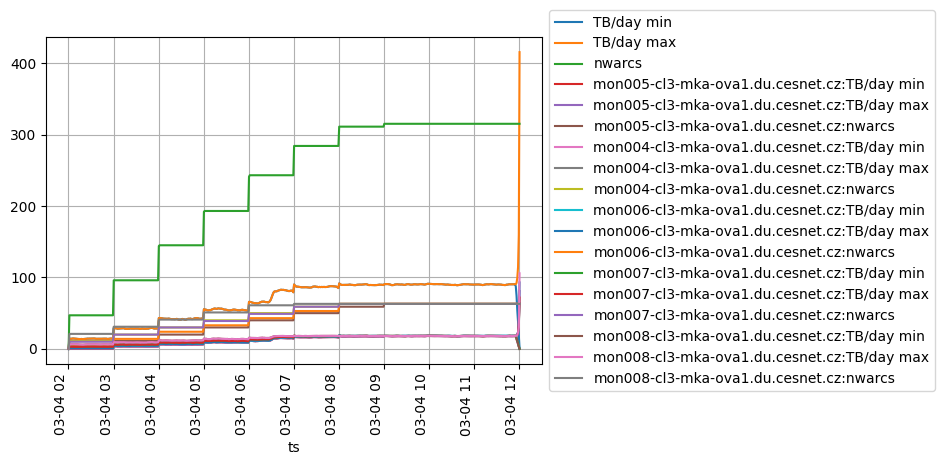

In [12]:
sdf.plot(x='ts', rot=90, grid=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

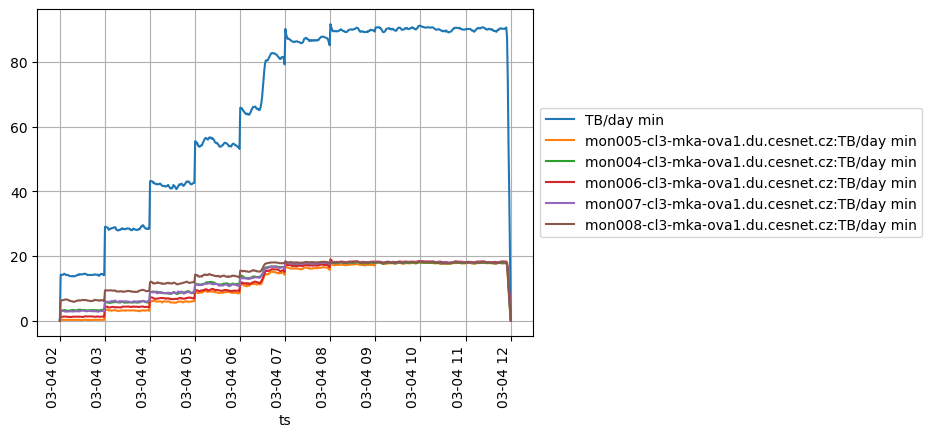

In [13]:
sdf1 = sdf[sdf.ts.describe().loc['min'] <= sdf.ts]
sdf1[[c for c in sdf1.columns if 'nwarc' not in c and 'max' not in c]].plot(x='ts', rot=90, grid=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='ts'>

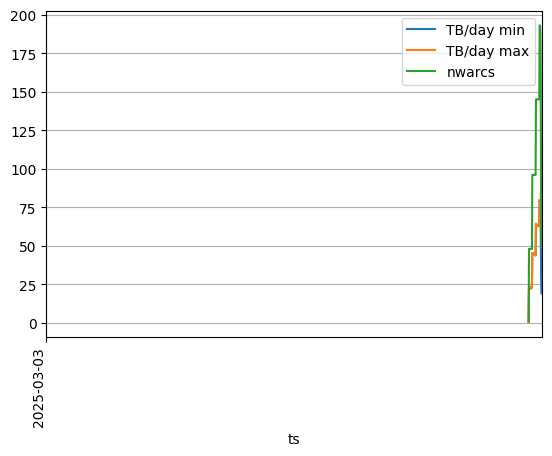

In [30]:
sdf.plot(x='ts', xticks=sdf.ts.dt.date.unique(), rot=90, grid=True)

<Axes: xlabel='ts'>

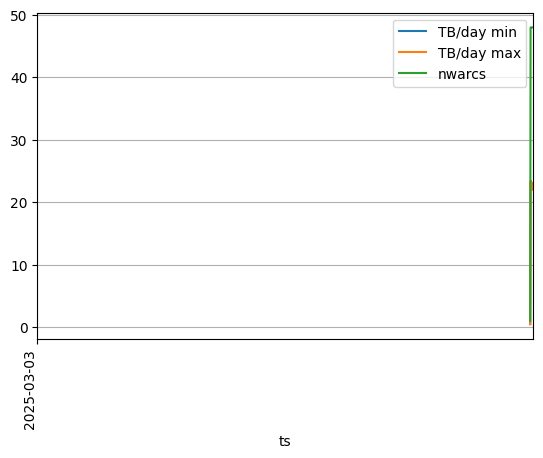

In [18]:
sdf1 = sdf[sdf.ts.describe().loc['25%'] > sdf.ts]
sdf1.plot(x='ts', xticks=sdf1.ts.dt.date.unique(), rot=90, grid=True)

<Axes: xlabel='ts'>

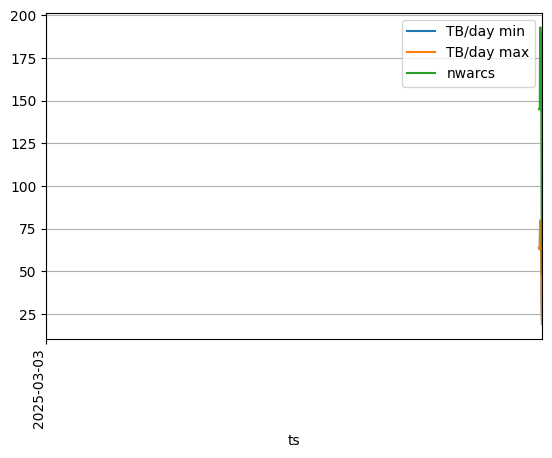

In [19]:
sdf1 = sdf[sdf.ts.describe().loc['75%'] < sdf.ts]
sdf1.plot(x='ts', xticks=sdf1.ts.dt.date.unique(), rot=90, grid=True)